In [11]:
import numpy as np
from scipy.integrate import odeint

In [74]:
def fill_theta_matrix(functions, data):
    assert type(data) == type(functions) == np.ndarray
    theta = np.zeros((data.shape[0], functions.shape[0]))
    for i in range(functions.shape[0]):
        function = functions[i]
        theta[:, i] = function(data[:, 0], data[:, 1])
    return theta

In [75]:
def pendulum_rhs(zt, dzt, coefficients, terms):
    #selected_terms =   [lambda x: terms[i]*coefficients[i] for i in range(len(terms)) if abs(coefficients[i]) > 1E-12]
    filled_theta_matrix = fill_theta_matrix(terms, np.array([zt, dzt]).T)
    return filled_theta_matrix @ coefficients.T
    

In [122]:
def pendulum_ode_step(y, t, coefficients, terms):
    zt, dzt = y
    return [dzt, *pendulum_rhs(np.array([zt]), np.array([dzt]), coefficients, terms)[0]]

In [125]:
def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t = np.linspace(0, dt * T, dt)
    sol = odeint(pendulum_ode_step, np.array([z0, dz0]),t, args=(coefficients, terms))

In [123]:
coeff = np.array([[-1, 0, 0]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y])
simulate_pendulum(np.pi-0.1, 0, coeff,)

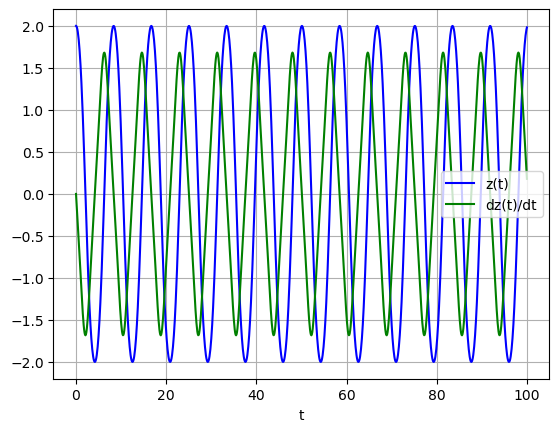

In [124]:
import matplotlib.pyplot as plt
plt.plot(t, sol[:, 0], 'b', label='z(t)')
plt.plot(t, sol[:, 1], 'g', label='dz(t)/dt')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()